In [2]:
!git clone https://github.com/aherrera3/qcdnum-17-01-14

fatal: destination path 'qcdnum-17-01-14' already exists and is not an empty directory.


### Aqui saco nombres de pdfs: "xuv" , ..., "xgl"

In [3]:
filenames = {}
for fname in glob("qcdnum-17-01-14/output/*"):
    filenames[float(re.search("(?<=_)[\d\.*]+(?=.csv)",fname).group(0))]=fname
pdfnames=pd.read_csv(fname, sep=" ").columns.values[1:]
pdfnames

array(['xuv', 'xdv', 'xubar', 'xdbar', 'xgl'], dtype=object)

# Figures for the fitted PDFs
#### It does not makes any fit

In [4]:
def fit_graphics(x,y,y_fit,title,ylabel,xlabel,xscale,save,show):
    # figures
    fig, ax = plt.subplots(
        nrows=2,                                # set two horizontal axes
        figsize=(7,7),
        sharex=True,                            # x axis will be shared among all subplots.
        gridspec_kw={"height_ratios":[4,2]}     # different size for upper and bottom axes
    )

    # upper graph: the fits
    plt.sca(ax[0])                                    # set the current axes to axis=0
    plt.title(title, fontsize=20)
    plt.plot(x, y_fit, c='k', linestyle=(0,(5,5)), label="fitted data")
    plt.scatter(x, y, s=3, label="original data")
    plt.ylabel(ylabel, fontsize=18)
    plt.legend()

    # bottom graph: the residuals
    plt.sca(ax[1])                                    # set the current axes to axis=1
    plt.scatter(x, y_fit-y, s=3)
    plt.xlabel(xlabel, fontsize=15)

    #fig.suptitle("Residuals")
    plt.xscale(xscale)
    plt.tight_layout()                                
    plt.savefig(save)
    plt.show() if show else plt.close()

In [5]:
# PDFs parametrization
def model_pdf_for_x(B, x):
    tolerance = 1e-6       # TODO: necessary? #Supongo que es para que no redonde 
    return (1-x+tolerance)**B[2] * x**B[1] * B[0] * (1 + B[3]*x + B[4]*x**2 + B[5]*np.log(x) + B[6]*np.log(x)**2)

In [6]:
initial_parameters={
      'xuv':[1.0, 0.05,   2.0, 4.0 , -6.5, 0.17  , 0.028],
     'xdv': [1.5, 0.003,   6.2, -2.0 , 18.0, 0.2   , 0.02],
     'xubar':[2.092522,0.146939,6.128849,-2.546240,1.990240,0.307638,0.045121],
     'xdbar':[    4.0        , 0.1,  15 , -3.6  , 5.3, 0.3 , 0.03],
     'xgl':[132.0, 0.52,  11.0, -2.5 , 4.8, 0.48 , 0.06]
}

In [7]:
betas_fit_pdf_for_x={}
column_names=['q_squared','a','b','c','d','e','f','g']
for pdfname in pdfnames:
    betas_fit_pdf_for_x[pdfname]=pd.DataFrame(columns=column_names)
    os.makedirs(f"./img/{pdfname}/Q2", exist_ok=True)
for q_squared in sorted(filenames.keys()):
    data=pd.read_csv(filenames[q_squared], sep=" ")
    for pdfname in pdfnames:
        x=data['x']
        y=data[pdfname]
        # fit and beta parameters
        fit=odr.ODR(odr.Data(x, y),
                     odr.Model(model_pdf_for_x),
                     beta0=initial_parameters[pdfname],
                     maxit=5000,
                     ifixx=np.zeros(len(data["x"]))
                     ).run()
        beta=fit.beta  
        row=[q_squared]+list(beta)
        betas_fit_pdf_for_x[pdfname]=betas_fit_pdf_for_x[pdfname].append(
            {column_names[i]:row[i] for i in range(len(column_names))}, ignore_index=True)
        fit_graphics(x,y,model_pdf_for_x(beta,x),str(q_squared),pdfname,'$x$','log',f"./img/{pdfname}/Q2/{q_squared}.png",False)
        #initial_parameters[pdfname]=beta

/tmp/ipykernel_12850/2548507909.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  betas_fit_pdf_for_x[pdfname]=betas_fit_pdf_for_x[pdfname].append(
/tmp/ipykernel_12850/2548507909.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  betas_fit_pdf_for_x[pdfname]=betas_fit_pdf_for_x[pdfname].append(
/tmp/ipykernel_12850/2548507909.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  betas_fit_pdf_for_x[pdfname]=betas_fit_pdf_for_x[pdfname].append(
/tmp/ipykernel_12850/2548507909.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  betas_fit_pdf_for_x[pdfname]=betas_fit_pdf_for_x[pdfname].append(
/tmp/ipykernel_12850/2548507909.py:20: F

# Figures for the fitted parameters

In [8]:
def model_parameter(p, q):
    x=q+1.5
    return -p[0]*np.log(x) +p[1]+ p[2]*x + p[3]*x**2+p[4]*x**(3/2)+p[5]*x**(1/2)

In [ ]:
betas_fit_pdf_for_parameters={}
for pdfname in pdfnames:
    betas_fit_pdf_for_parameters[pdfname]={}
    os.makedirs(f"./img/{pdfname}/parameters", exist_ok=True)
    for parameter in betas_fit_pdf_for_x[pdfname].columns.values[1:]:
        y=betas_fit_pdf_for_x[pdfname][parameter]
        x=np.log(betas_fit_pdf_for_x[pdfname]['q_squared']/2.56**2)
        initial_parameters1=[1,1,1,1,1,1]
        fit=odr.ODR(odr.Data(x, y),
                    odr.Model(model_parameter),
                    beta0=initial_parameters1,
                    maxit=5000,
                    ).run()
        beta=fit.beta
        fit_graphics(x,y,model_parameter(beta,x),f"{pdfname} - {parameter}",str(parameter),'$Q^2$','linear',f"./img/{pdfname}/parameters/{parameter}.png",False)
        betas_fit_pdf_for_parameters[pdfname][parameter]=beta

# Function to integrate

In [9]:
def pdf_for_x_and_q_squared(x,q_squared,pdfname):
    parameters=[]
    for parameter in betas_fit_pdf_for_parameters[pdfname]:
        parameters.append(model_parameter(betas_fit_pdf_for_parameters[pdfname][parameter], np.log(q_squared/2.56**2)))
    return model_pdf_for_x(parameters, x)

# Results

ERROR! Session/line number was not unique in database. History logging moved to new session 104


IndexError: list index out of range

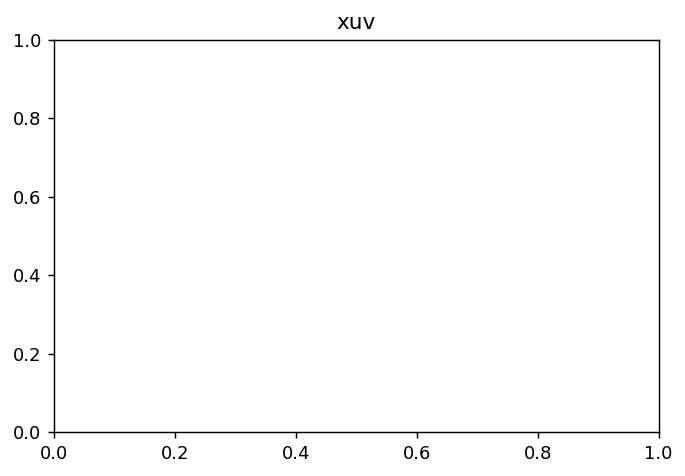

In [10]:
x=pd.read_csv(filenames[2.56], sep=" ")['x']
for pdfname in pdfnames:
    plt.title(pdfname)
    for q_squared in np.linspace(2.56,1000,100):
        y=pdf_for_x_and_q_squared(x,q_squared,pdfname)
        plt.plot(x,y)
        plt.xscale('log')
    plt.show()

In [ ]:
def xdbar(x,q):
    return pdf_for_x_and_q_squared(x,q,'xdbar')

In [ ]:
from scipy import integrate
def opts0(*args, **kwargs):
    return {'points':[0.2*args[2] + 0.5 + 0.25*args[0]]}
integrate.nquad(xdbar, [[0.5,1],[3.5,1000000]], full_output=True)